# database interface & plotting examples

In [113]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import boto3
import base64
import os
from botocore.exceptions import ClientError
import json
import psycopg2
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import sys
import traceback
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class DB:
    """database interface class"""
    @staticmethod
    def connect(params: dict) -> [psycopg2.extensions.connection, psycopg2.extensions.cursor]:
        """
            @brief: connects to the database

            @params:
                params: dictionary of db connection parameters

            @returns:
                db: the database
                cur: the cursor
        """
        if "datasource.username" in params:
            temp = {
                "user": params["datasource.username"],
                "password": params["datasource.password"],
                "database": params["datasource.database"],
                "host": params["datasource.url"],
                "port": params["datasource.port"]
            }
            params = temp
        try:
            print("[INFO] connecting to db.")
            db = psycopg2.connect(**params)
            print("[INFO] connected.")
            cur = db.cursor()
        except Exception as e:
            print("[ERROR] failed to connect to db.")
            print(e)
            return []
        return [db, cur]

    @staticmethod
    def execute(sql_query: str, database: psycopg2.extensions.connection) -> pd.DataFrame:
        """
            @brief: shorthand sql style execution

            @params:
                sql_query: the query string to execute
                database: the database to execute on

            @returns: a pandas table of the query results
        """
        try:
            if('insert' in sql_query):
                print("insert here")
                pd.read_sql_query(sql_query, database)
            else:
                return pd.read_sql_query(sql_query, database)
        except Exception as e:
            print(e)
            print(traceback.print_exc())
            if ('NoneType' in str(e)):
                print("ignoring error")
            return pd.DataFrame()
        
    @staticmethod
    def get_tables(db: psycopg2.extensions.connection) -> pd.DataFrame:
        """Returns a DataFrame of the tables in a given database"""
        return DB.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""", db)

    @staticmethod
    def get_fields(tb: str, db: psycopg2.extensions.connection) -> pd.DataFrame:
        """Returns the fields (column headers) for a given table"""
        return DB.execute("""SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = '{}';""".format(tb), db)

    
class Utils:
    """
        @brief: static class for utility functions

        @definitions:
            get_aws_secret(secret_name, region_name)
    """

    @staticmethod
    def get_aws_secret(secret_name: str="", region_name: str="us-east-1") -> {}:
        """
            @brief: retrieves a secret stored in AWS Secrets Manager. Requires AWS CLI and IAM user profile properly configured.

            @input:
                secret_name: the name of the secret
                region_name: region of use, default=us-east-1

            @output:
                secret: dictionary
        """
        client = boto3.session.Session().client(service_name='secretsmanager', region_name=region_name)
        secret = '{"None": "None"}'
        if (len(secret_name) < 1):
            print("[ERROR] no secret name provided.")
        else:
            try:
                res = client.get_secret_value(SecretId=secret_name)
                if 'SecretString' in res:
                    secret = res['SecretString']
                elif 'SecretBinary' in res:
                    secret = base64.b64decode(res['SecretBinary'])
                else:
                    print("[ERROR] secret keys not found in response.")
            except ClientError as e:
                print(e)

        return json.loads(secret)

    @staticmethod
    def get_config(filename: str=r'', section: str='postgresql') -> {}:
        """
            @brief: [DEPRECIATED] parses a database configuration file

            @params:
                filename: configuraiton file with .ini extension
                section: the type of db

            @returns:
                config: dictionary of database configuration settings
        """
        from configparser import ConfigParser
        parser = ConfigParser()
        config = {}

        try:
            parser.read(filename)
        except:
            print("[ERROR] failed to read file. does it exist?")
            return config

        if parser.has_section(section):
            params = parser.items(section)
            for param in params:
                config[param[0]] = param[1]
        else:
            print('[ERROR] Section {0} not found in the {1} file'.format(section, filename))
            return config

        return config


In [761]:
params = Utils.get_aws_secret("/secret/uav_db")
db, cur =  DB.connect(params)
del(params)
DB.get_tables(db)

[INFO] connecting to db.
[INFO] connected.


,table_name
0,model_tb
1,uav_tb
2,eqc_battery_tb
3,eq_motor_tb
4,degradation_parameter_tb
5,mission_tb
6,pg_stat_statements
7,battery_sensor_tb
8,flight_sensor_tb
9,experiment_tb


## get a list of experiments & mission_ids

In [828]:
experiments_df = DB.execute("""select et.* from experiment_tb et;""", database=db)

mission_ids = list(experiments_df['mission_ids'].values)
mission_ids = [idx.split('-') for idx in mission_ids]
mission_ids = [np.arange(int(x), int(y)) for x, y in mission_ids]
mission_idx = [np.arange(1, len(x)+1) for x in mission_ids]
assert len(mission_idx) == len(mission_ids), "[ERROR] index mappings should be of same length"
experiments = [(x, y) for x,y in zip(mission_ids, mission_idx)]
print(len(experiments))

14


## access the mission and degredation data for a given experiment

In [791]:
experiment = 0 # 0 based
print(experiments_df['notes'].iloc[experiment])
mission_ids = experiments[experiment][0]
mission_idx = experiments[experiment][1]

mission_data_df = DB.execute(f"""select mt.* from mission_tb mt where mt.id >= {mission_ids[0]} and mt.id <= {mission_ids[-1]} order by mt.id asc;""", database=db)
mission_data_df['idx'] = mission_idx
mission_data_df = mission_data_df.drop(columns={'dt_start', 'dt_stop'})
print(len(mission_data_df))
mission_data_df.head()

first experiment with degradation curves downsampled to about 100 missions. motor degradation was too high
51


,id,trajectory_id,stop_code,prior_rul,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,battery_id,uav_id,idx
0,1,3,3,18.0,17.8342,1301.9481,0.4780,4.0083,1.2455,3.2464,0.6710,0.1012,3.1186,0.9820,2,1,1
1,2,3,3,18.0,17.8371,1302.1040,0.4361,3.9500,1.2476,3.2242,0.6687,0.0929,3.1642,0.9797,2,1,2
2,3,3,3,18.0,17.8325,1301.9721,0.4868,4.0095,1.3173,3.4164,0.6756,0.1317,3.1493,1.0203,2,1,3
3,4,15,3,18.0,17.6346,1283.8769,0.4784,4.0084,1.3431,3.7596,0.8461,0.0705,3.2933,1.0571,2,1,4
4,5,11,3,18.0,16.3617,1218.7356,0.4833,3.9880,1.3421,3.4620,0.7247,0.1588,3.5650,1.0172,2,1,5


In [650]:
for i in zip(mission_ids, mission_idx):
    print(i)

(1, 1)
(2, 2)
(3, 3)
(4, 4)
(5, 5)
(6, 6)
(7, 7)
(8, 8)
(9, 9)
(10, 10)
(11, 11)
(12, 12)
(13, 13)
(14, 14)
(15, 15)
(16, 16)
(17, 17)
(18, 18)
(19, 19)
(20, 20)
(21, 21)
(22, 22)
(23, 23)
(24, 24)
(25, 25)
(26, 26)
(27, 27)
(28, 28)
(29, 29)
(30, 30)
(31, 31)
(32, 32)
(33, 33)
(34, 34)
(35, 35)
(36, 36)
(37, 37)
(38, 38)
(39, 39)
(40, 40)
(41, 41)
(42, 42)
(43, 43)
(44, 44)
(45, 45)
(46, 46)
(47, 47)
(48, 48)
(49, 49)
(50, 50)
(51, 51)


### view summary statistics of the mission data

In [588]:
mission_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,131.0,696.000000,37.960506,631.0000,663.50000,696.0000,728.50000,761.0000
trajectory_id,131.0,11.946565,2.954301,3.0000,10.00000,13.0000,14.00000,20.0000
stop_code,131.0,2.816794,0.508414,1.0000,3.00000,3.0000,3.00000,3.0000
prior_rul,131.0,16.613964,1.263457,13.7188,15.57330,17.0758,17.69250,18.5685
flight_time,131.0,14.790105,2.057571,1.0396,13.93420,14.8288,16.35630,19.6329
distance,131.0,1093.139221,147.703723,87.3520,1047.79255,1083.3364,1218.55020,1449.1421
z_end,131.0,0.517110,0.063170,0.4182,0.48805,0.5126,0.55095,0.9627
v_end,131.0,3.683755,0.438303,2.4711,3.48870,3.9057,3.99375,4.0377
avg_pos_err,131.0,1.336629,0.055145,1.2296,1.31875,1.3399,1.36310,1.7696
max_pos_err,131.0,3.740719,0.353017,3.1439,3.52835,3.6659,3.87080,5.1263


In [180]:
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
degradation_data_df.head()

,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,631,631,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02000,0.0,0.0,2,2,1
1,632,632,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02000,0.0,0.0,2,2,1
2,633,633,13.913262,0.89,0.0,0.0,0.001771,0.00099,0.0,0.0,0.251445,0.01975,0.0,0.0,2,2,1
3,634,634,14.897995,0.88,0.0,0.0,0.000586,0.00098,0.0,0.0,0.232806,0.01950,0.0,0.0,2,2,1
4,635,635,15.500000,0.87,0.0,0.0,0.000896,0.00097,0.0,0.0,0.216816,0.01925,0.0,0.0,2,2,1


## view summary statistics of the degradation data

In [8]:
degradation_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,131.0,696.000000,37.960506,631.000000,663.500000,696.000000,728.500000,761.000000
mission_id,131.0,696.000000,37.960506,631.000000,663.500000,696.000000,728.500000,761.000000
q_deg,131.0,13.493197,1.257465,10.785498,12.545135,13.626380,14.561224,15.500000
q_var,131.0,0.417557,0.216912,0.200000,0.250000,0.260000,0.585000,0.900000
q_slope,131.0,-0.028664,0.051856,-0.163271,-0.060285,-0.032770,-0.003733,0.261229
q_intercept,131.0,15.278515,4.375167,0.000000,14.321135,15.567552,17.371333,22.736088
r_deg,131.0,0.013608,0.017023,0.000100,0.001694,0.005009,0.020550,0.064233
r_var,131.0,0.000419,0.000306,0.000100,0.000100,0.000360,0.000685,0.001000
r_slope,131.0,0.000422,0.000517,-0.000241,0.000043,0.000167,0.000800,0.001830
r_intercept,131.0,-0.031403,0.045675,-0.173827,-0.057739,-0.005386,0.000000,0.006323


## some data exploration
### looking at correlations between average position error and motor degradation

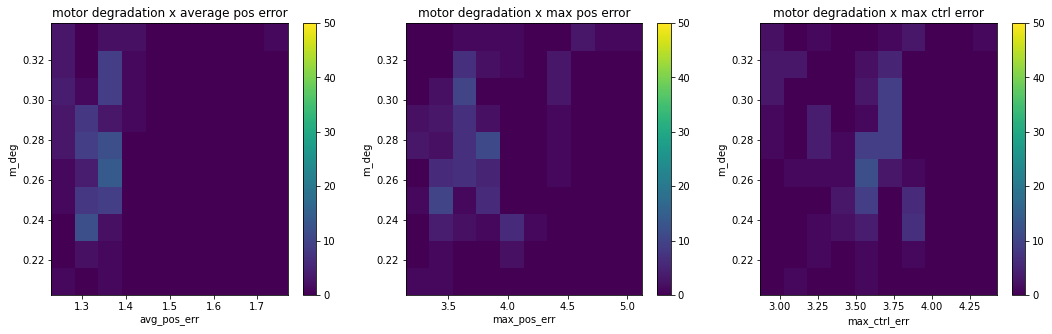

In [9]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist2d(mission_data_df['avg_pos_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('avg_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x average pos error")

plt.subplot(1,3,2)
plt.hist2d(mission_data_df['max_pos_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max pos error")

plt.subplot(1,3,3)
plt.hist2d(mission_data_df['max_ctrl_err'], degradation_data_df['m_deg'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_ctrl_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max ctrl error")

plt.show()

### what about correlations with the degradation rate of change?

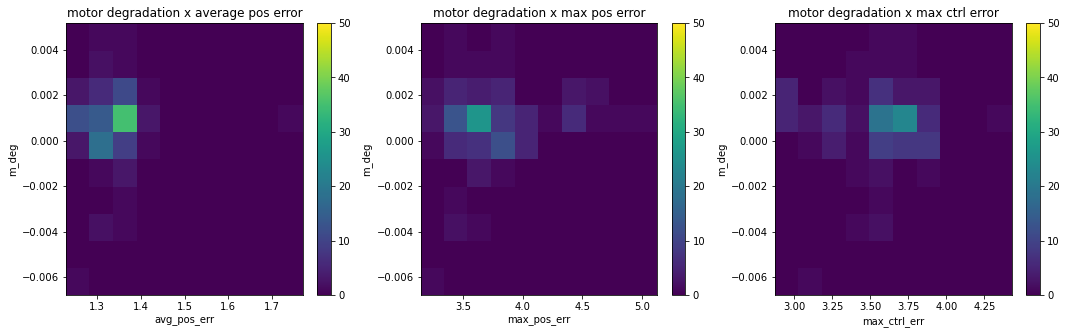

In [10]:
assert degradation_data_df['m_slope'].isnull().values.any() == False, "[WARN] fillna values on the m_slope column"
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist2d(mission_data_df['avg_pos_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('avg_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x average pos error")

plt.subplot(1,3,2)
plt.hist2d(mission_data_df['max_pos_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_pos_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max pos error")

plt.subplot(1,3,3)
plt.hist2d(mission_data_df['max_ctrl_err'], degradation_data_df['m_slope'], bins=(10,10), vmax=50)
plt.colorbar()
plt.xlabel('max_ctrl_err')
plt.ylabel('m_deg')
plt.title("motor degradation x max ctrl error")

plt.show()

# view feature distributions

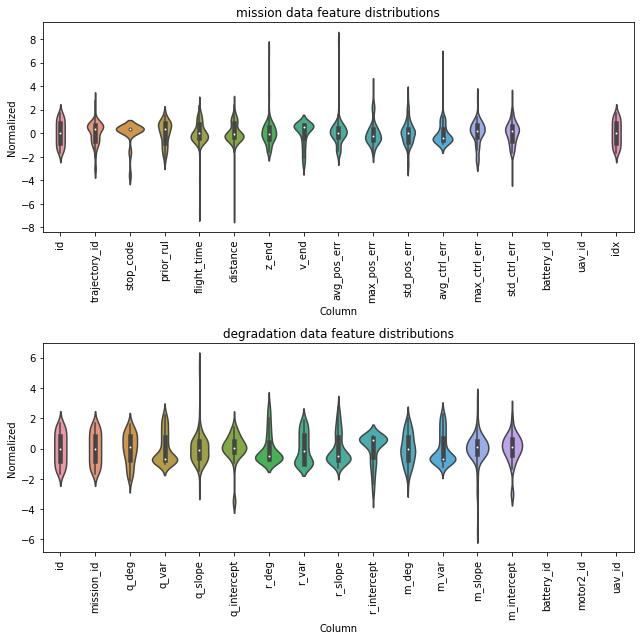

In [11]:
degradation_data_normalized = (degradation_data_df - degradation_data_df.mean()) / degradation_data_df.std()
mission_data_normalized = (mission_data_df - mission_data_df.mean()) / mission_data_df.std()

plt.figure(figsize=(9, 9))
plt.subplot(2,1,1)
mission_plt = mission_data_normalized.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=mission_plt)
_ = ax.set_xticklabels(mission_data_df.keys(), rotation=90)
plt.title("mission data feature distributions")

plt.subplot(2,1,2)
degradation_plt = degradation_data_normalized.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=degradation_plt)
_ = ax.set_xticklabels(degradation_data_df.keys(), rotation=90)
plt.title("degradation data feature distributions")
plt.tight_layout()

# view degradation parameter plots for a single experiment

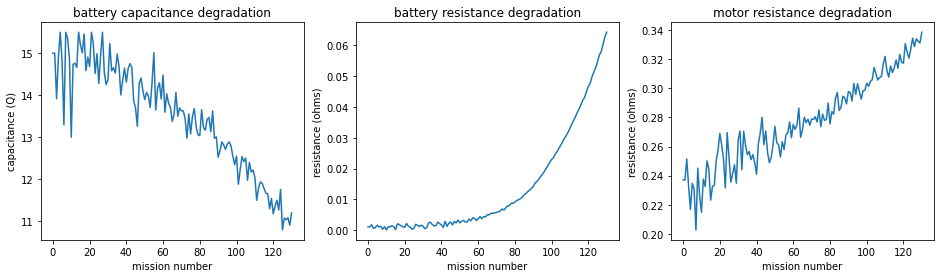

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
degradation_data_df['q_deg'].plot()
plt.title('battery capacitance degradation')
plt.xlabel('mission number')
plt.ylabel('capacitance (Q)')

plt.subplot(1,3,2)
degradation_data_df['r_deg'].plot()
plt.title('battery resistance degradation')
plt.xlabel('mission number')
plt.ylabel('resistance (ohms)')

plt.subplot(1,3,3)
degradation_data_df['m_deg'].plot()
plt.title('motor resistance degradation')
plt.xlabel('mission number')
plt.ylabel('resistance (ohms)')

plt.show()

# view RUL (flight time) estimation plots for all experiments

In [802]:
# get the rul from each experiment
ruls = []
q_degs = []
r_degs = []
m_degs = []
errs = []

for i in range(0, len(experiments)):
    print(i, experiments_df['notes'].iloc[i])
    mission_ids = experiments[i][0]
    mission_idx = experiments[i][1]

    mission_data_df = DB.execute(f"""select mt.* from mission_tb mt where mt.id >= {mission_ids[0]} and mt.id <= {mission_ids[-1]} order by mt.id asc;""", database=db)
    mission_data_df['idx'] = mission_idx
    mission_data_df = mission_data_df.drop(columns={'dt_start', 'dt_stop'})
    
    degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
    degradation_data_df = degradation_data_df.fillna(0)
    
    ruls.append(mission_data_df['prior_rul'].values)
    errs.append(mission_data_df['avg_pos_err'].values)
    q_degs.append(degradation_data_df['q_deg'].values)
    r_degs.append(degradation_data_df['r_deg'].values)
    m_degs.append(degradation_data_df['m_deg'].values)

0 first experiment with degradation curves downsampled to about 100 missions. motor degradation was too high
1 second experiment with motor degradation back to original (500 cycles) and battery degradation at half (180 cycles)
2 third experiment exact repeat of second experiment
3 4th experiment, allowed for better rul updates - still seeing true system failures before digital twin failures
4 failed to write flight data for mission 526, error during simulation, matlab crashed and the simulation restarted form scratch with a new experiment
5 now simulating digital twin 4x and using mean values, includes random trajectory exploration of path > rul time, stopped before experiment finished
6 simulating digital twin 4x, random trajectory exploration, digital twin does not inform true system, mission 742 (and others), why did true system fail when it had worse degradradation parameters than the digital twin? are there trajectories with higher crash rates? (trajectory 10)
7 same as above, dig

In [14]:

def get_samples(vals, exclude=[0,2]):
    samples = []    
    for i in range(0, max(len(val) for val in vals)):
        temp = []
        for j in range(0, len(vals)):
            if j in exclude:
                continue
            if(i < len(vals[j])):
                temp.append(vals[j][i])
        samples.append(temp)
    return samples

In [15]:
exclude=[0,2]
1 in exclude

False

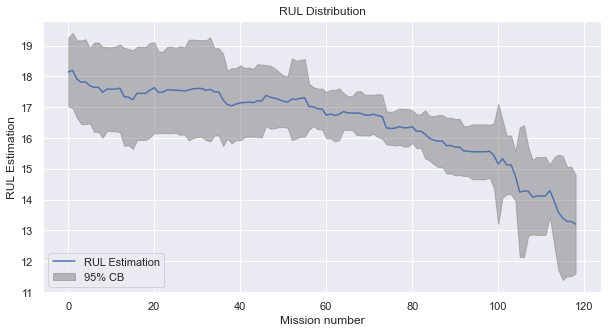

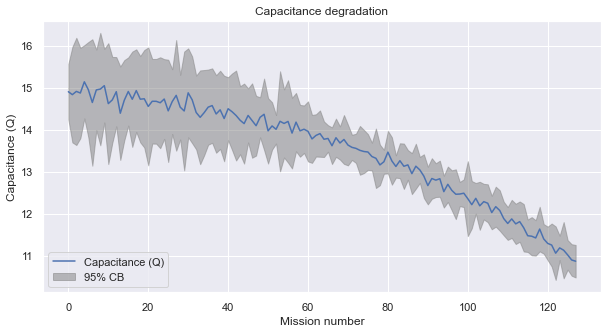

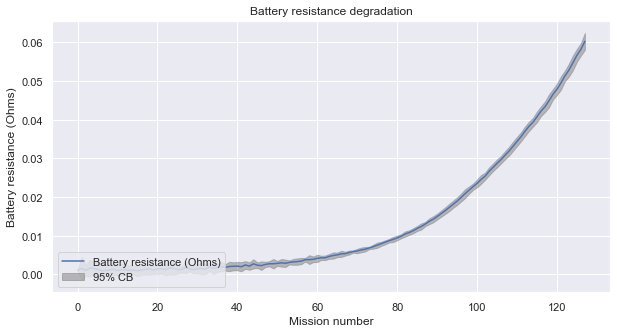

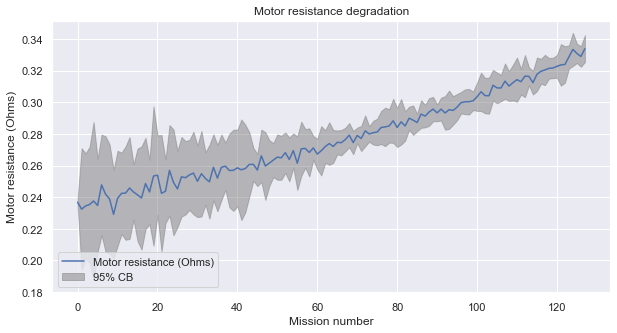

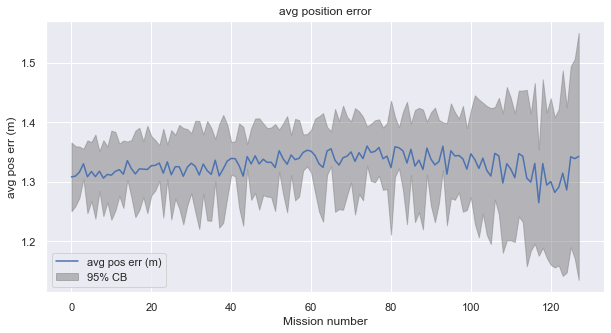

In [793]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

def plot_distribution(samples=[], 
                      return_distribution=True, 
                      label="RUL Estimation",
                      title="RUL Distribution",):
    mus = []
    stds = []

    # samples is a multi-dimensional list, where each index represents a run number
    # which always starts at 0 and increments until end of life, and at each index is 
    # a list of rul estimations from all experiments for that mission number
    # for example, there are 9 rul estimates at run number = 19, which contain
    # [16.5433, 18.9283, 17.7767, 18.2302, 17.0758, 16.7842, 17.5781, 17.4173, 17.0094]
    count = tf.Variable(0)
    for sample in samples:
        s = tf.convert_to_tensor(sample, dtype=tf.float32)
        count = count + len(s)
        mu = tf.math.reduce_mean(s, axis=0)
        std = tf.math.reduce_std(s, axis=0)
        #print(mu, std)
        mus.append(mu)
        stds.append(std)
    mu_t = tf.convert_to_tensor(mus, dtype=tf.float32)
    std_t = tf.convert_to_tensor(stds, dtype=tf.float32)


    plt.figure(figsize=(10,5))

    x = tf.range(0, mu_t.shape[0], delta=1)
    plt.fill_between(x, 
                     mu_t-2*std_t, 
                     mu_t+2*std_t, 
                     color='grey', 
                     alpha=.5, label="95% CB")
    plt.plot(x, mu_t, label=label)
    plt.ylabel(label)
    plt.xlabel('Mission number')
    plt.title(title)
    plt.legend(loc=3)
    #plt.text(-4, 11.8, f"*Calculated from data on {count} missions", backgroundcolor='white')
    plt.show()

    if return_distribution:
        return [mu_t, std_t]
    
samples=get_samples(ruls, exclude=[0,2])
rul_mu, rul_std = plot_distribution(samples=samples[9:-4], return_distribution=True)

samples=get_samples(q_degs, exclude=[0,2])
qd_mu, qd_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="Capacitance (Q)", 
                                 title="Capacitance degradation")

samples=get_samples(r_degs, exclude=[0,2])
rd_mu, rd_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="Battery resistance (Ohms)", 
                                 title="Battery resistance degradation")

samples=get_samples(m_degs, exclude=[0,2])
md_mu, md_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="Motor resistance (Ohms)", 
                                 title="Motor resistance degradation")

samples=get_samples(errs, exclude=[0,2])
ed_mu, ed_std = plot_distribution(samples=samples[:-4], 
                                 return_distribution=True, 
                                 label="avg pos err (m)", 
                                 title="avg position error")

In [794]:
mission_data_df.head()
mission_data_df['index'] = mission_data_df.index
mission_data_df.head()

,id,trajectory_id,stop_code,prior_rul,flight_time,distance,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,battery_id,uav_id,idx,index
0,1,3,3,18.0,17.8342,1301.9481,0.4780,4.0083,1.2455,3.2464,0.6710,0.1012,3.1186,0.9820,2,1,1,0
1,2,3,3,18.0,17.8371,1302.1040,0.4361,3.9500,1.2476,3.2242,0.6687,0.0929,3.1642,0.9797,2,1,2,1
2,3,3,3,18.0,17.8325,1301.9721,0.4868,4.0095,1.3173,3.4164,0.6756,0.1317,3.1493,1.0203,2,1,3,2
3,4,15,3,18.0,17.6346,1283.8769,0.4784,4.0084,1.3431,3.7596,0.8461,0.0705,3.2933,1.0571,2,1,4,3
4,5,11,3,18.0,16.3617,1218.7356,0.4833,3.9880,1.3421,3.4620,0.7247,0.1588,3.5650,1.0172,2,1,5,4


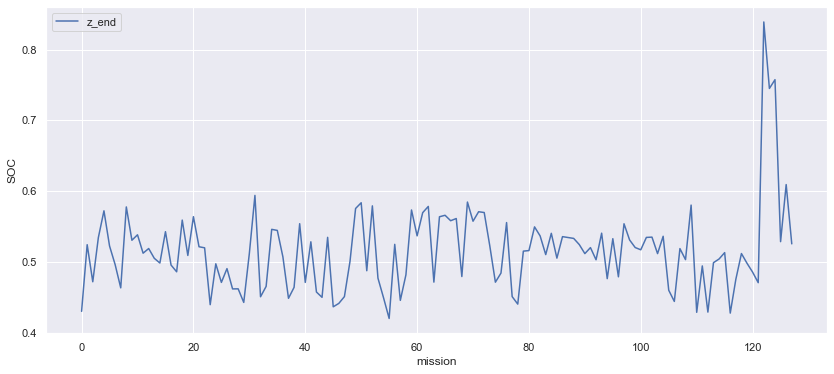

In [820]:
#mission_data_df['z_end'] = mission_data_df['z_end']/200
plt.figure(figsize=(14,6))
plt.plot(mission_data_df['z_end'], label='z_end')
#plt.scatter(x=mission_data_df.index, y=mission_data_df['trajectory_id'])
axe = plt.gca()
plt.legend()
plt.xlabel('mission')
plt.ylabel('SOC')
plt.show()

In [808]:
mission_data_df['trajectory_id'].unique().min()

3

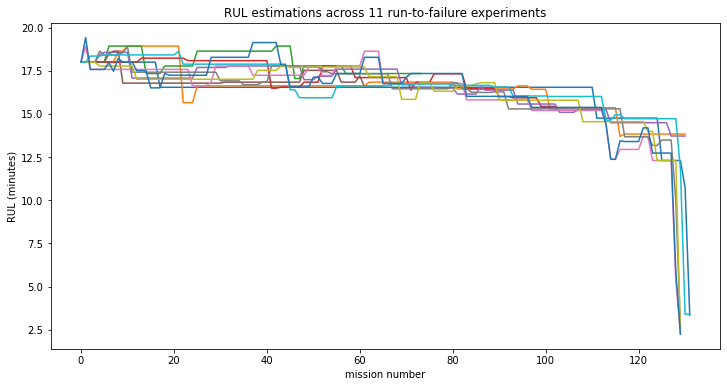

In [18]:
plt.figure(figsize=(12,6))
for i in range(0, len(ruls)):
    if i == 0 or i == 2:
        continue
    plt.plot(ruls[i])
    
    
plt.title(f"RUL estimations across {len(ruls)-2} run-to-failure experiments")
plt.ylabel("RUL (minutes)")
plt.xlabel("mission number")
plt.show()

# view degradation parameter plots for all runs

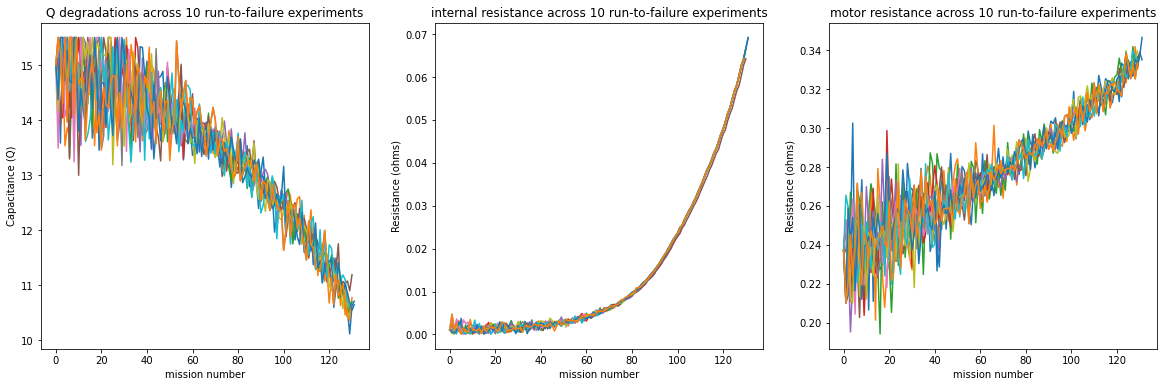

In [19]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
i = 0
for q in q_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(q)
    
plt.title("Q degradations across 10 run-to-failure experiments")
plt.ylabel("Capacitance (Q)")
plt.xlabel("mission number")

plt.subplot(1,3,2)
i = 0
for r in r_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(r)
    
plt.title("internal resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")

plt.subplot(1,3,3)
i = 0
for m in m_degs:
    if i == 0:
        i = 1
        continue
    plt.plot(m)
    
plt.title("motor resistance across 10 run-to-failure experiments")
plt.ylabel("Resistance (ohms)")
plt.xlabel("mission number")

plt.show()

# look at the twin parameter data

In [20]:
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
twin_params_df.tail()

,id,mission_id,trajectory_id,rul_hat,flight_time,distance,v_end,z_end,avg_err,q_deg,r_deg,m_deg,stop1,stop2,stop3,uav_id
4043,4044,1551,20,17.461667,17.426667,1320.547308,3.904420,0.405843,1.453637,0.004846,12.859870,0.276714,1,0,0,1
4044,4045,1551,14,16.769167,14.834167,1099.691784,3.904003,0.489788,1.499260,0.004846,12.859870,0.276714,0,0,1,1
4045,4046,1551,14,16.769167,14.833333,1099.451839,3.910385,0.505285,1.485872,0.004844,13.263996,0.280576,0,0,1,1
4046,4047,1551,14,16.769167,14.833333,1099.399413,3.909785,0.499963,1.503915,0.004841,13.120078,0.274096,0,0,1,1
4047,4048,1551,14,16.769167,14.833333,1099.838904,3.914312,0.510384,1.511213,0.004714,13.409883,0.272416,0,0,1,1


## view voltage ending 

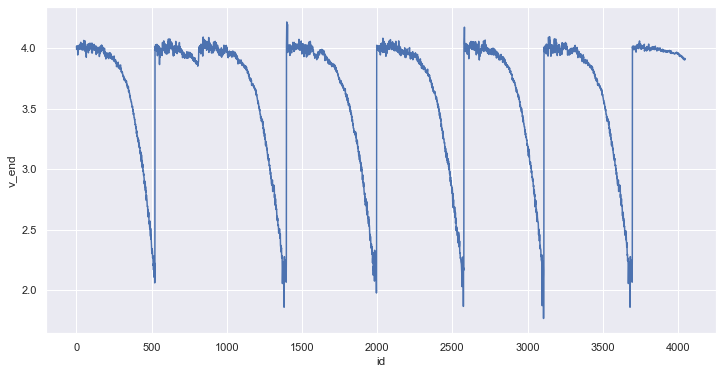

In [21]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=twin_params_df, x="id", y="v_end")
plt.show()

# view ending charge

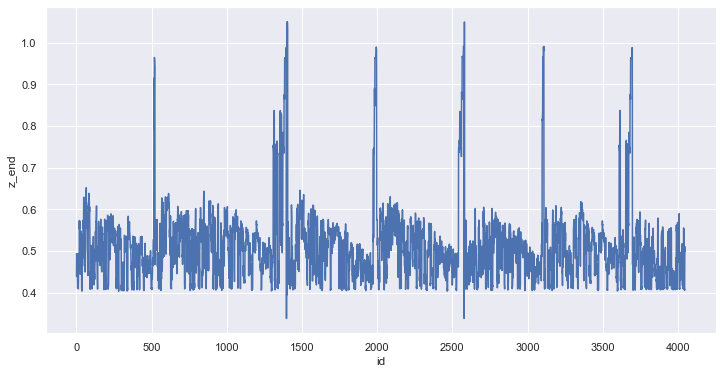

In [22]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=twin_params_df, x="id", y="z_end")
plt.show()

# view degradation slopes

In [23]:
degradation_data_df.head()

,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,1360,1360,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02000,0.0,0.0,2,2,1
1,1361,1361,15.500000,0.89,0.0,0.0,0.004678,0.00099,0.0,0.0,0.210102,0.01975,0.0,0.0,2,2,1
2,1362,1362,15.250537,0.88,0.0,0.0,0.000808,0.00098,0.0,0.0,0.222026,0.01950,0.0,0.0,2,2,1
3,1363,1363,14.300126,0.87,0.0,0.0,0.002619,0.00097,0.0,0.0,0.245294,0.01925,0.0,0.0,2,2,1
4,1364,1364,15.500000,0.86,0.0,0.0,0.000940,0.00096,0.0,0.0,0.223809,0.01900,0.0,0.0,2,2,1


In [114]:
%matplotlib notebook
%matplotlib inline
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

from scipy.signal import medfilt


def animate_degradation(deg, slope, intercept):
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    line, = ax.plot([], [], lw=2)
    plt.plot(deg)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)

    # animation function. This is called sequentially
    def animate(i):
        x = tf.range(start=i-2, limit=i+2, delta=.25)
        qm = slope[i]
        qb = intercept[i]
#         qm = degradation_data_df['q_slope'].iloc[i]
#         qb = degradation_data_df['q_intercept'].iloc[i]
        qy = qm * x + qb
        line.set_data(x, qy)
        return (line,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=len(slope), interval=50, blit=True)

    return HTML(anim.to_html5_video())

# single run to failure experiment battery capacitance degradation
- 128 missions in this case

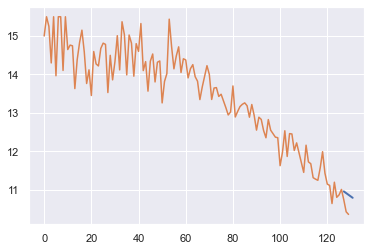

In [182]:
slope_filt = medfilt(degradation_data_df['q_slope'].values, 9)
inter_filt = medfilt(degradation_data_df['q_intercept'].values, 9)
animate_degradation(degradation_data_df['q_deg'], slope_filt, inter_filt)

# single run to failure experiment battery resistance degradation
- 128 missions in this case

In [28]:
slope_filt = medfilt(degradation_data_df['r_slope'].values, 9)
inter_filt = medfilt(degradation_data_df['r_intercept'].values, 9)
animate_degradation(degradation_data_df['r_deg'], slope_filt, inter_filt)

<IPython.core.display.Javascript object>

# single run to failure experiment motor degradation

In [29]:
slope_filt = medfilt(degradation_data_df['m_slope'].values, 9)
inter_filt = medfilt(degradation_data_df['m_intercept'].values, 9)
animate_degradation(degradation_data_df['m_deg'], slope_filt, inter_filt)

<IPython.core.display.Javascript object>

# rul estimate of 12 experiments (> 1500 missions)
### view slope

In [103]:
lookback = 8
horizon = 4
slopes = []
ints = []
for i in range(0, len(rul_mu)):
    if i <= lookback:
        slopes.append(0)
        ints.append(0)
    else:
        x = tf.range(start=i-lookback, limit=i, delta=1)
        y = rul_mu[x[0].numpy():x[-1].numpy()+1]
        z = np.polyfit(x.numpy(), y.numpy(), 1)
        slopes.append(z[0])
        ints.append(z[1])
    
slope_filt = medfilt(np.array(slopes), 9)
inter_filt = medfilt(np.array(ints), 9)
animate_degradation(rul_mu, slope_filt, inter_filt)

<IPython.core.display.Javascript object>

# clustering analysis

In [104]:
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering

stop1 = twin_params_df.pop('stop1')
stop2 = twin_params_df.pop('stop2')
stop3 = twin_params_df.pop('stop3')

In [110]:
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
print(len(degradation_data_df))
degradation_data_df.head()

1553


,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,m_slope,m_intercept,battery_id,motor2_id,uav_id
0,1,1,15.000000,0.90,0.0,0.0,0.001100,0.00100,0.0,0.0,0.237100,0.02500,0.0,0.0,2,2,1
1,2,2,13.877173,0.89,0.0,0.0,0.003257,0.00099,0.0,0.0,0.250991,0.02475,0.0,0.0,2,2,1
2,3,3,15.500000,0.88,0.0,0.0,0.001059,0.00098,0.0,0.0,0.171652,0.02450,0.0,0.0,2,2,1
3,4,4,14.934967,0.87,0.0,0.0,0.001094,0.00097,0.0,0.0,0.272745,0.02425,0.0,0.0,2,2,1
4,5,5,13.927817,0.86,0.0,0.0,0.001899,0.00096,0.0,0.0,0.264777,0.02400,0.0,0.0,2,2,1


# min max scale to range [0,1]

In [183]:
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)
twin_params_df = (twin_params_df - twin_params_df.min()) / (twin_params_df.max() - twin_params_df.min())
degradation_data_df = (degradation_data_df - degradation_data_df.min()) / (degradation_data_df.max() - degradation_data_df.min())
X1 = twin_params_df[['v_end', 'z_end', 'avg_err']]
X2 = degradation_data_df[['q_deg', 'q_slope', 'q_intercept', 'r_deg', 'r_slope', 'r_intercept', 'm_deg', 'm_slope', 'm_intercept']]
#X2 = X2[X2['q_slope'] > 0]
Xs = [X1.values, X2.values]
twin_params_df = DB.execute("""select tpt.* from twin_params_tb tpt;""", database=db)
degradation_data_df = DB.execute(f"""select dpt.* from degradation_parameter_tb dpt where dpt.mission_id >= {mission_ids[0]} and dpt.mission_id <= {mission_ids[-1]} order by dpt.mission_id asc;""", database=db)
degradation_data_df = degradation_data_df.fillna(0)

********************* twin params *******************


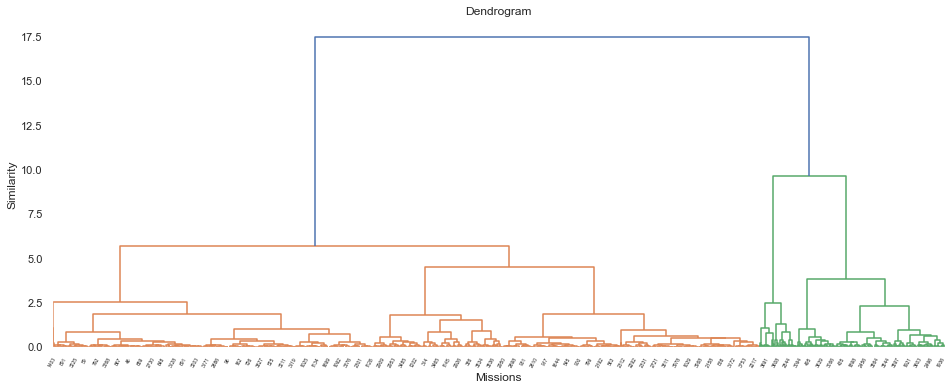

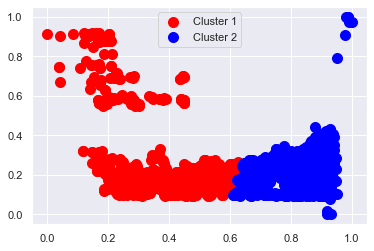

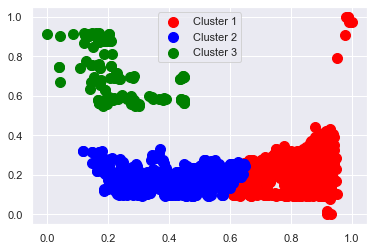

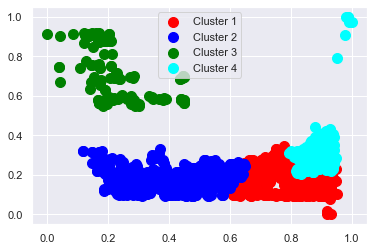

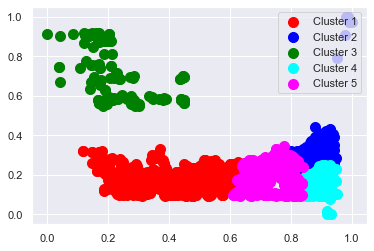

C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  f"KMeans is known to have a memory leak on Windows "


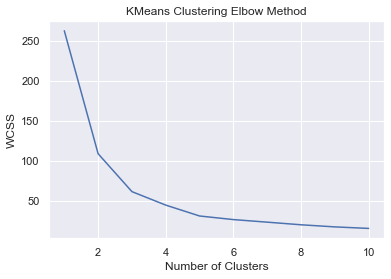

*********************************************************
********************* degradation data *******************


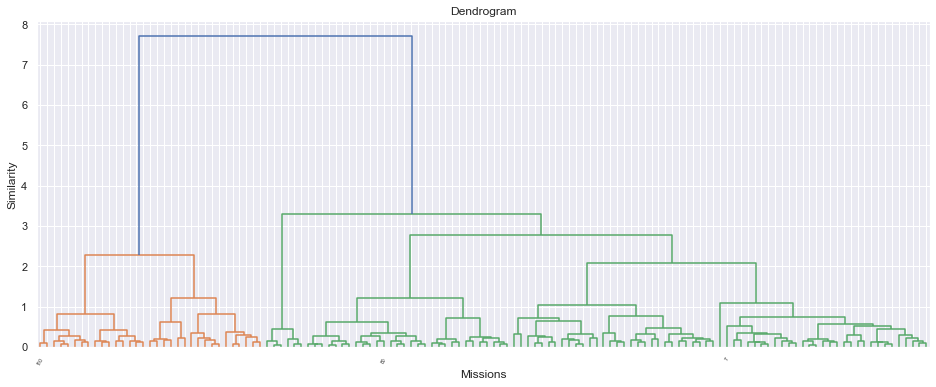

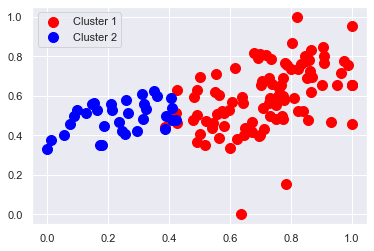

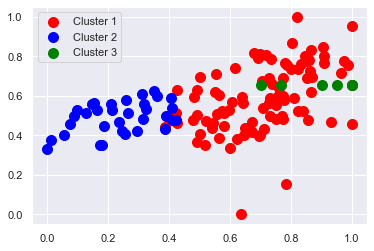

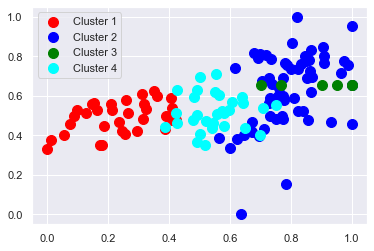

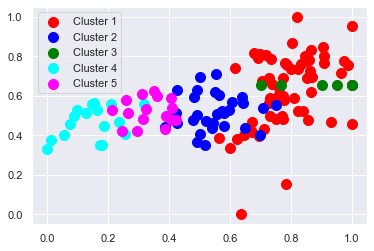

C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


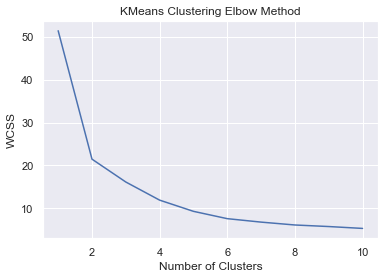

*********************************************************


In [184]:
%matplotlib inline
names = ["twin params", "degradation data"]
j = 0

keep_clusters = []

for X in Xs:
    
    print(f"********************* {names[j]} *******************")
    j = j + 1
    plt.figure(figsize=(16,6))
    dendrogram = hc.dendrogram(hc.linkage(X, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Missions')
    plt.ylabel("Similarity")
    ax = plt.gca()
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 50 != 0]
    plt.xticks(rotation=60)
    plt.show()
    
    clust2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    y_pred = clust2.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.legend()
    plt.show()

    clust3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
    y_pred = clust3.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
    plt.legend()
    plt.show()
    keep_clusters.append(clust3)

    clust4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
    y_pred = clust4.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
    plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
    plt.legend()
    plt.show()

    clust5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
    y_pred = clust5.fit_predict(X)
    plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
    plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
    plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
    plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
    plt.scatter(X[y_pred == 4, 0], X[y_pred == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
    plt.legend()
    plt.show()

    from sklearn.cluster import KMeans
    wcss = []
    for i in range(1, 11):
        km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=31)
        km.fit(X)
        wcss.append(km.inertia_)

    plt.plot(range(1,11), wcss)
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.title("KMeans Clustering Elbow Method")
    plt.show()
    print("*********************************************************")

In [185]:
len(mission_data_df)

130

In [218]:
sum(mission_data_df['cluster'] == 3)

6

In [367]:
mission_data_df['cluster'] = keep_clusters[1].labels_
mission_data_df['cluster'] = mission_data_df['cluster'] + 1
len(mission_data_df[mission_data_df['stop_code'] == mission_data_df['cluster']])

11

In [239]:
twin_params_df['cluster'] = keep_clusters[0].labels_
twin_params_df['cluster'] = twin_params_df['cluster'] + 1

In [240]:
print(sum(stop1), sum(stop2), sum(stop3))
print(twin_params_df['cluster'].value_counts())

429 90 3531
1    3227
2     675
3     169
Name: cluster, dtype: int64


429 90 3531
3    3227
1     675
2     169
Name: cluster, dtype: int64


429 90 3531
3    3227
1     675
2     169
Name: cluster, dtype: int64
0.868828297715549
0.7209530827806436


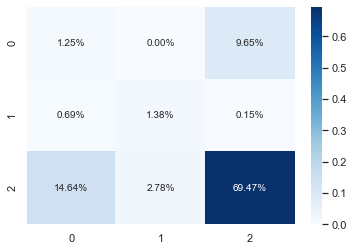

In [368]:
mission_data_df['cluster'] = keep_clusters[1].labels_
mission_data_df['cluster'] = mission_data_df['cluster'] + 1


twin_params_df['cluster'] = keep_clusters[0].labels_
twin_params_df['cluster'] = twin_params_df['cluster'] + 1
temp = twin_params_df[['stop1', 'stop2', 'stop3', 'cluster']].iloc[:]
temp['cluster'].replace({1:4}, inplace=True)
temp['cluster'].replace({2:1}, inplace=True)
temp['cluster'].replace({3:2}, inplace=True)
temp['cluster'].replace({4:3}, inplace=True)

print(sum(stop1), sum(stop2), sum(stop3))
print(temp['cluster'].value_counts())


actual = np.ones(len(temp), dtype=int)
for i in range(0, len(actual)):
    if temp['stop1'].iloc[i]:
        actual[i] = 1
    elif temp['stop2'].iloc[i]:
        actual[i] = 2
    elif temp['stop3'].iloc[i]:
        actual[i] = 3
    else:
        print("error")
        
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(actual, temp['cluster'].values)/len(temp['cluster'])
sns.heatmap(cm, annot=True, fmt=".2%", cmap='Blues')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict everything is 3
null_hypothesis = np.ones((len(temp['cluster']),))*3

res = null_hypothesis - actual
res[res != 0] = 1
sum(res)
print(1-sum(res)/len(res))

res = temp['cluster'].values - actual
res[res != 0] = 1
sum(res)
print(1-sum(res)/len(res))

# Feature selection of mission + degradation data on rul

In [824]:
data_df = DB.execute("select dpt.*, mt.* from degradation_parameter_tb dpt join mission_tb mt on mt.id = dpt.mission_id order by mission_id desc;", db)
data_df.head()
data_df[data_df.isnull().any(axis=1)]
data_df = data_df.fillna(0)
data_df[data_df.isnull().any(axis=1)]
data_df = data_df[data_df['prior_rul'] > 10]

In [825]:
data_df.head()

,id,mission_id,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,...,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,battery_id,uav_id
1,1619,1619,10.478152,0.25,-0.092328,22.517134,0.062589,0.0001,0.001715,-0.159339,...,0.5254,2.3546,1.4515,3.6725,0.6726,0.2236,3.2601,1.0946,2,1
2,1618,1618,10.650947,0.25,-0.089567,22.193118,0.060135,0.0001,0.001640,-0.150143,...,0.6092,0.9836,1.3294,5.2724,0.7164,0.2933,3.4855,1.0051,2,1
3,1617,1617,11.382871,0.25,-0.049539,17.418654,0.058179,0.0001,0.001602,-0.145503,...,0.5285,2.4704,1.3498,3.3762,0.6866,0.4337,3.4760,0.9718,2,1
4,1616,1616,10.892924,0.25,-0.088574,22.104463,0.056724,0.0001,0.001571,-0.141748,...,0.7575,2.5439,1.2452,3.7023,0.7655,0.6271,3.7969,0.8008,2,1
5,1615,1615,11.035111,0.25,-0.037697,15.916682,0.054831,0.0001,0.001510,-0.134410,...,0.7451,2.5898,1.2200,3.4668,0.6874,0.6801,3.4391,0.7194,2,1


In [821]:
#y = data_df.pop('prior_rul').values
data_df.pop('id')
mid = data_df.pop('mission_id')
stp = data_df.pop('stop_code')
data_df.pop('dt_start')
data_df.pop('dt_stop')
data_df.pop('battery_id')
data_df.pop('uav_id')
data_df.pop('motor2_id')
#data_df = normalize(data_df)
#X = data_df.values
data_df.head()

Execution failed on sql: select dpt.*, mt.* from degradation_parameter_tb dpt join mission_tb mt on mt.id = dpt.mission_id order by mission_id desc;
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

unable to rollback
None


Traceback (most recent call last):
  File "C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\pandas\io\sql.py", line 1681, in execute
    cur.execute(*args, **kwargs)
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\pandas\io\sql.py", line 1685, in execute
    self.con.rollback()
psycopg2.InterfaceError: connection already closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-2-5fbff017a1c5>", line 53, in execute
    return pd.read_sql_query(sql_query, database)
  File "C:\Users\darrahts\anaconda3\envs\tf2x\lib\site-packages\pandas\io\sql.py", line 383, in read_sql_query
    chunksize=chunksize,
  File "C:\Users\darraht

KeyError: 'prior_rul'

In [521]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2

best = f_regression(X, y)
#best_features = best.fit(X, y)
scores_df = pd.DataFrame(best_features.scores_)

cols_df = pd.DataFrame(data_df.columns)

scores_df = pd.concat([cols_df, scores_df], axis=1)
best = SelectKBest(score_func=mutual_info_regression, k=12)
best_features = best.fit(X, y)
mutual_info = pd.DataFrame(best_features.scores_)
scores_df = pd.concat([scores_df, mutual_info], axis=1)

scores_df.columns = ['parameter', 'f regression', 'mutual info']
scores_df.sort_values(by='f regression', ascending=False)

,parameter,f regression,mutual info
7,r_intercept,0.950150,0.949565
4,r_deg,0.932755,0.930776
16,v_end,0.918588,0.918525
6,r_slope,0.891044,0.897465
13,flight_time,0.829366,0.838678
14,distance,0.826346,0.820073
8,m_deg,0.789958,0.788372
5,r_var,0.735241,0.739988
0,q_deg,0.689382,0.692801
20,avg_ctrl_err,0.664752,0.660935


In [522]:
scores_df.sort_values(by='mutual info', ascending=False)

,parameter,f regression,mutual info
7,r_intercept,0.950150,0.949565
4,r_deg,0.932755,0.930776
16,v_end,0.918588,0.918525
6,r_slope,0.891044,0.897465
13,flight_time,0.829366,0.838678
14,distance,0.826346,0.820073
8,m_deg,0.789958,0.788372
5,r_var,0.735241,0.739988
0,q_deg,0.689382,0.692801
20,avg_ctrl_err,0.664752,0.660935


# Model evaluation

In [565]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns

# json dict to hold model information
results = {}

In [524]:
data_df.isna().sum()

q_deg            0
q_var            0
q_slope          0
q_intercept      0
r_deg            0
r_var            0
r_slope          0
r_intercept      0
m_deg            0
m_var            0
m_slope          0
m_intercept      0
trajectory_id    0
flight_time      0
distance         0
z_end            0
v_end            0
avg_pos_err      0
max_pos_err      0
std_pos_err      0
avg_ctrl_err     0
max_ctrl_err     0
std_ctrl_err     0
dtype: int64

In [624]:
train_df = data_df.sample(frac=.8, random_state=32)
train_mid = mid.loc[train_df.index]
test_df = data_df.drop(train_df.index)
test_mid = mid.loc[test_df.index]
train_labels = train_df.pop('prior_rul')
test_labels = test_df.pop('prior_rul')

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_df))

# the model

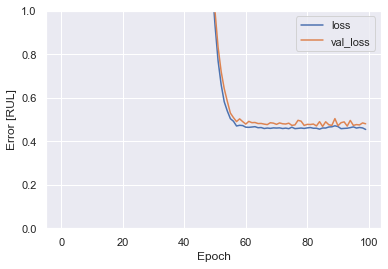

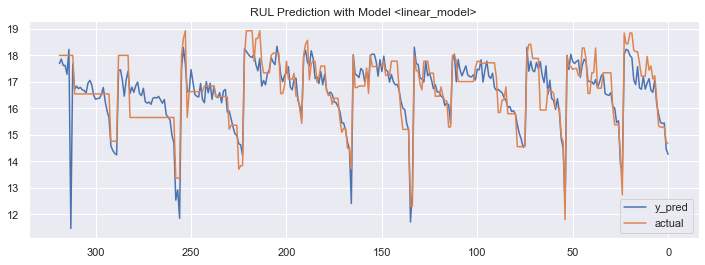

In [625]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_df))

learning_rate = .01
layer_1_units = 1
epochs        = 100
val_split     = .2


linear_model = tf.keras.Sequential([normalizer, tf.keras.layers.Dense(units=layer_1_units)])

names = ['linear_model']
models = [linear_model]

for model in zip(models, names):

    model[0].compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss='mean_absolute_error')

    history = linear_model.fit(train_df, train_labels, verbose=0, epochs=epochs, validation_split=val_split)

    y_pred = model[0].predict(test_df)

    plot_loss(history)


    plt.figure(figsize=(12,4))
    plt.plot(y_pred, label='y_pred')
    plt.plot(test_labels.values, label='actual')
    plt.legend(loc='best')
    plt.title(f"RUL Prediction with Model <{name}>")
    ax = plt.gca()
    ax.invert_xaxis()
    plt.show()

In [829]:
mission_ids = np.concatenate(mission_ids)
mission_idx = np.concatenate(mission_idx)

In [831]:
len(mission_ids)

1599

In [737]:
mids = []
for i in range(0, len(test_df)):
    _id = data_df['mission_id'].iloc[i]
    res = np.where(mission_ids == _id)[0]
    if len(res) > 0:
        mids.append(mission_idx[res[0]])
    else:
        print(i, _id, res)
        test_df = test_df[test_df['mission_id'] != _id]

157 830 []
313 52 []


In [735]:
len(mids)

318

In [757]:
test_df['midx'] = mids
test_df = test_df.sort_values(by='midx')
midx = test_df.pop('midx')
mids = test_df.pop('mission_id')
y_pred = models[0].predict(test_df)

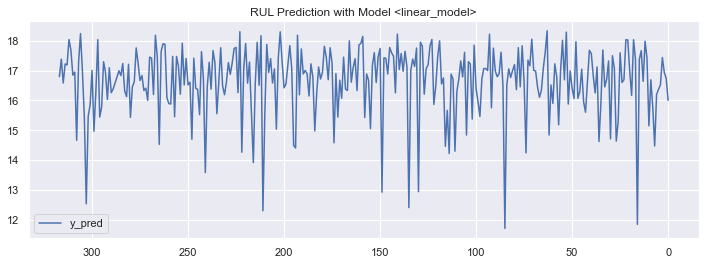

In [759]:
plt.figure(figsize=(12,4))
plt.plot(y_pred, label='y_pred')
#plt.plot(test_labels.values, label='actual')
plt.legend(loc='best')
plt.title(f"RUL Prediction with Model <{name}>")
ax = plt.gca()
ax.invert_xaxis()
plt.show()

In [748]:
test_df.head(10)

,q_deg,q_var,q_slope,q_intercept,r_deg,r_var,r_slope,r_intercept,m_deg,m_var,...,z_end,v_end,avg_pos_err,max_pos_err,std_pos_err,avg_ctrl_err,max_ctrl_err,std_ctrl_err,mission_id,midx
7,11.020349,0.25,-0.074467,20.387068,0.051347,0.0001,0.001422,-0.124048,0.320917,0.005,...,0.4705,2.6465,1.2485,3.9837,0.7337,0.0627,3.1555,1.0169,1613,122
10,11.594850,0.25,-0.079366,20.960306,0.046627,0.0001,0.001320,-0.112150,0.321661,0.005,...,0.5117,2.8354,1.3605,4.5274,0.7299,0.2300,2.8875,1.0546,1610,119
21,12.596005,0.25,-0.028824,15.335979,0.032015,0.0001,0.001001,-0.077375,0.311814,0.005,...,0.5187,3.1838,1.3724,3.6251,0.7539,0.0544,3.6843,1.0939,1599,108
22,11.596534,0.25,-0.084359,20.959012,0.030808,0.0001,0.000976,-0.074865,0.315183,0.005,...,0.4440,3.2380,1.3636,3.6272,0.7434,0.0463,3.5620,1.0851,1598,107
25,12.265616,0.25,-0.046357,17.104199,0.027621,0.0001,0.000924,-0.069631,0.304521,0.005,...,0.5116,3.3232,1.2506,3.5082,0.7581,0.2430,3.7370,0.9831,1595,104
30,12.769099,0.25,-0.027789,15.336601,0.022613,0.0001,0.000827,-0.060205,0.302809,0.005,...,0.5309,3.4470,1.2635,3.5092,0.7582,0.2442,3.7174,0.9825,1590,99
36,12.984373,0.25,-0.033625,15.885220,0.017366,0.0001,0.000633,-0.042447,0.302951,0.005,...,0.5029,3.5803,1.3393,3.6753,0.7501,0.0561,3.6104,1.0723,1584,93
54,13.556854,0.25,0.002825,13.469569,0.007565,0.0001,0.000247,-0.011375,0.281476,0.005,...,0.4712,3.8365,1.3472,3.5140,0.7251,0.1423,3.6040,1.0279,1566,75
62,13.273163,0.25,-0.028262,15.446701,0.005514,0.0001,0.000179,-0.006777,0.279356,0.005,...,0.5581,3.8967,1.3744,4.3832,0.7382,0.2307,2.9709,1.0360,1558,67
63,14.045938,0.25,-0.011031,14.509570,0.005095,0.0001,0.000158,-0.005455,0.272111,0.005,...,0.5658,3.9061,1.3618,3.5313,0.7694,0.0839,3.5693,1.0594,1557,66


320


In [569]:
def normalize(data_df):
    data_df = data_df[:]
    data_df = (data_df - data_df.min()) / (data_df.max() - data_df.min())
    return data_df

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RUL]')
  plt.legend()
  plt.grid(True)

In [383]:
conn = psycopg2.connect(dbname="tsdb", user="postgres",
         password="8rK2Q@99Ad0uo!Wb",host="144.126.248.145",port=5432)
cur = conn.cursor()

In [822]:
params = Utils.get_aws_secret("/secret/uav_db")
db, cur =  DB.connect(params)
del(params)
DB.get_tables(db)

[INFO] connecting to db.
[INFO] connected.


,table_name
0,model_tb
1,uav_tb
2,eqc_battery_tb
3,eq_motor_tb
4,degradation_parameter_tb
5,mission_tb
6,pg_stat_statements
7,battery_sensor_tb
8,flight_sensor_tb
9,experiment_tb
